### Name   : Ibadullah Hayat
### Reg No : B23F0001AI010
### Section : F23 AI-GREEN

## Lab 03: Linear Regression on Insurance Dataset

Objective: Build a linear regression model to predict insurance charges using features like age, BMI, smoking status, etc., with both scikit-learn and from-scratch gradient descent.

Step 1: Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

I’m using pandas for data handling, scikit-learn for the baseline model, and numpy for the custom gradient descent implementation. All visualizations use matplotlib and seaborn

In [3]:
# Load the insurance dataset
df = pd.read_csv('insurance.csv')
print(" Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

 Dataset loaded successfully!
Dataset shape: (1338, 7)

First 5 rows:
   age  gender     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


The dataset contains 1338 records with features: age, gender, bmi, children, smoker, region, and target charges.

Step 2: Data Exploration & Cleaning
python

In [4]:
# Basic statistics
print("\n Dataset Statistics:")
print(df.describe())

# Check for missing values
print("\n Missing Values:")
print(df.isnull().sum())


 Dataset Statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

 Missing Values:
age         0
gender      0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


No missing values! But we have categorical variables (gender, smoker, region) that need encoding.

In [5]:
# One-hot encode categorical variables
df_processed = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], drop_first=True)
print(f"\n After encoding, dataset shape: {df_processed.shape}")


 After encoding, dataset shape: (1338, 9)


I used drop_first=True to avoid multicollinearity (dummy variable trap). Now all features are numeric.

Step 3: Outlier Removal (Z-Score Method)

In [6]:
# Compute Z-scores for all numeric columns
z_scores = np.abs(stats.zscore(df_processed.select_dtypes(include=np.number)))

# Identify outliers (|Z| > 3)
outliers = (z_scores > 3).any(axis=1)
num_outliers = outliers.sum()
print(f"\n Detected {num_outliers} outlier rows (Z-score > 3)")

# Remove outliers
df_clean = df_processed[~outliers]
print(f" Final dataset shape after cleaning: {df_clean.shape}")


 Detected 29 outlier rows (Z-score > 3)
 Final dataset shape after cleaning: (1309, 9)


Removing outliers improves model stability—especially important for linear regression, which is sensitive to extreme values.

Step 4: Exploratory Data Analysis (EDA)

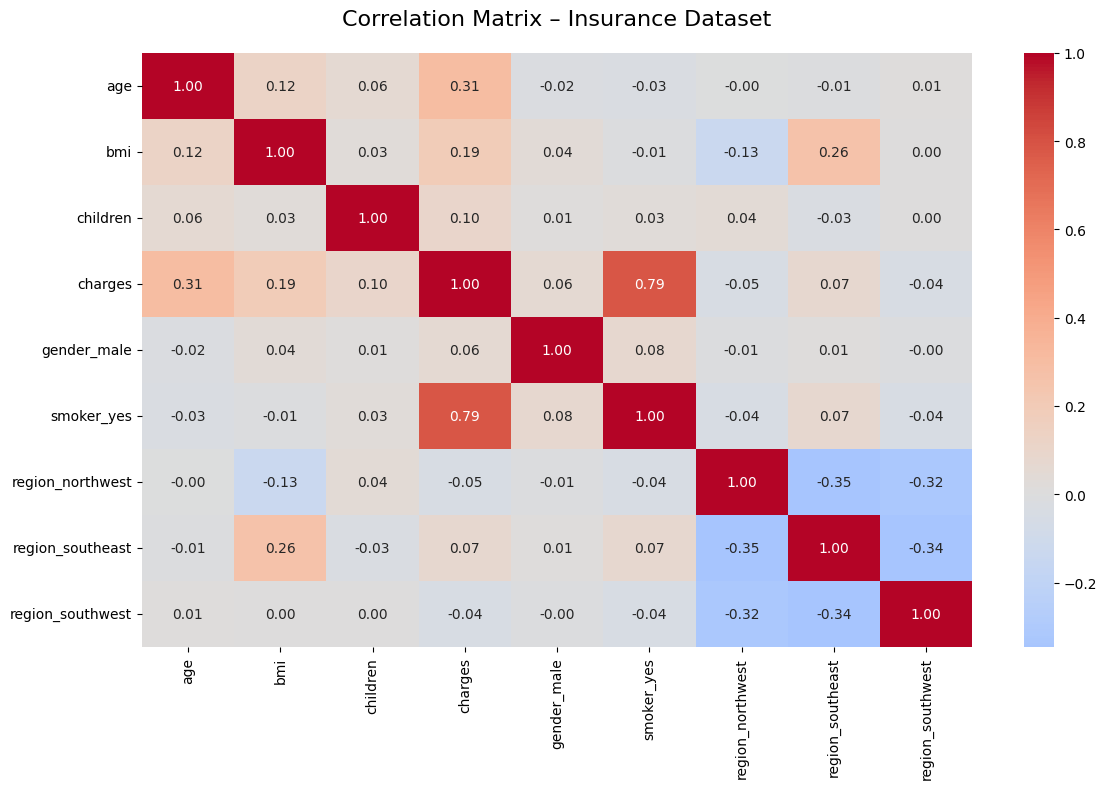


 Top correlations with target variable (charges):
charges             1.000000
smoker_yes          0.785129
age                 0.305263
bmi                 0.191453
children            0.100438
region_southeast    0.074829
gender_male         0.059455
region_southwest   -0.042922
region_northwest   -0.045847
Name: charges, dtype: float64


In [8]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Correlation Matrix – Insurance Dataset', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Top correlations with 'charges'
print("\n Top correlations with target variable (charges):")
print(correlation_matrix['charges'].sort_values(ascending=False))

 Key Insight:

smoker_yes has very high correlation (r = 0.79) with charges ,
 smoking drastically increases insurance cost.
age and bmi also show moderate positive relationships.

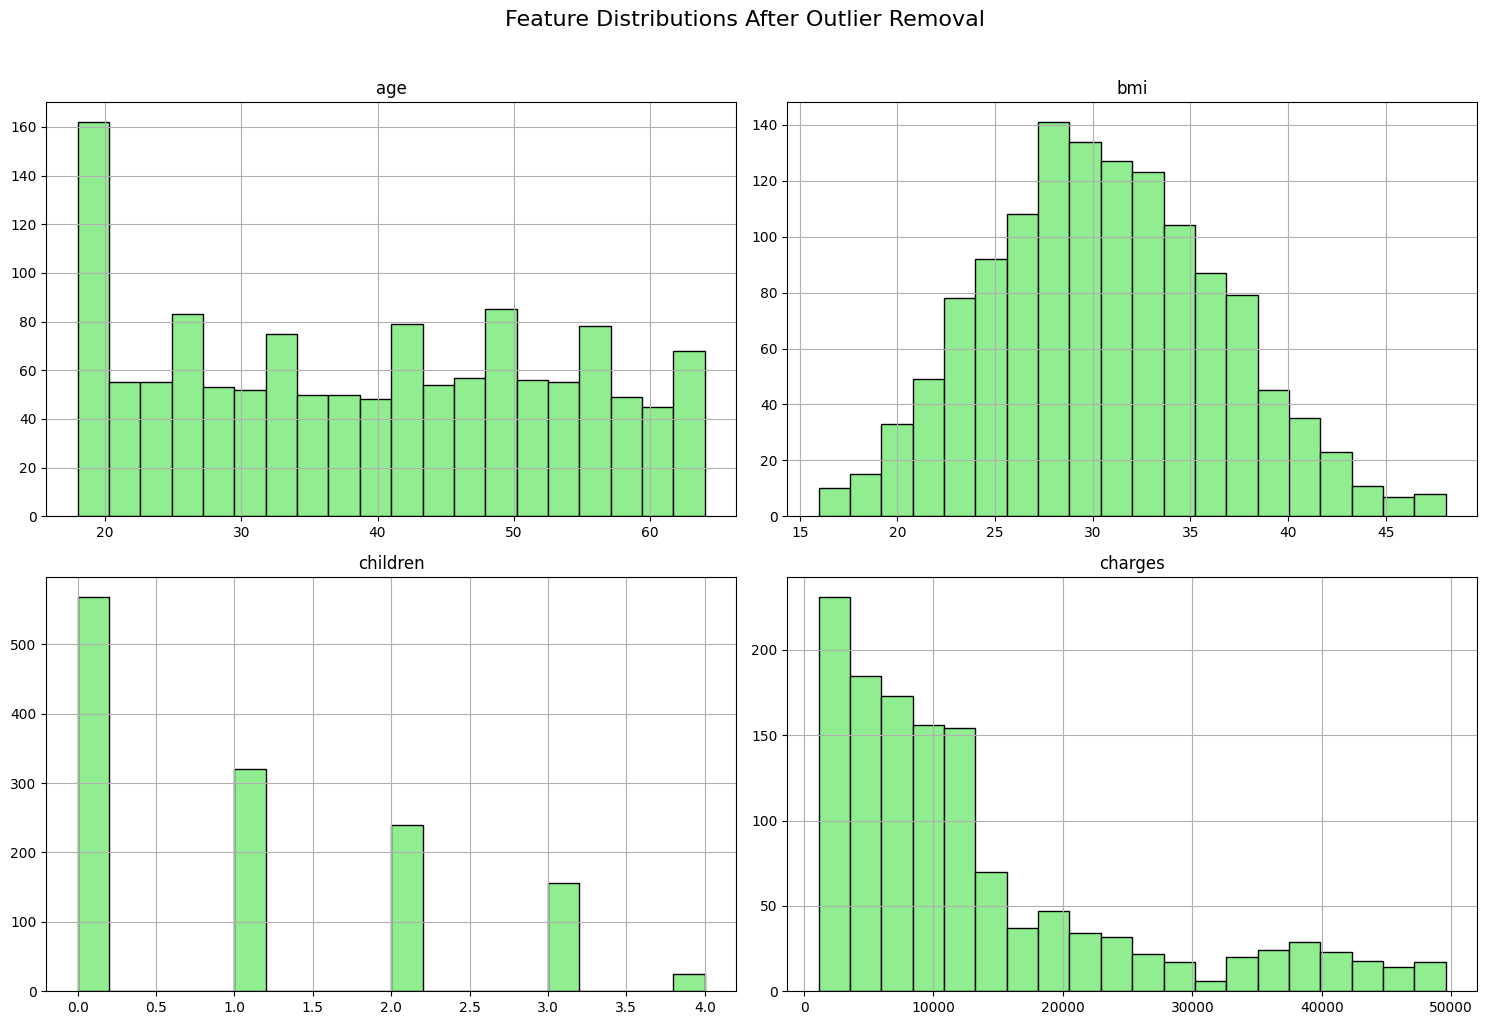

In [16]:
# Feature distributions (after outlier removal)
df_clean.hist(bins=20, figsize=(15, 10), color='lightgreen', edgecolor='black')
plt.suptitle('Feature Distributions After Outlier Removal', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

The distributions look much cleaner now,no extreme tails from outliers.

Step 5: Model Preparation

In [9]:
# Define features (X) and target (y)
X = df_clean.drop(columns='charges')
y = df_clean['charges']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Training set size: {X_train_scaled.shape[0]}")
print(f" Test set size: {X_test_scaled.shape[0]}")
print(f" Features used: {list(X.columns)}")


 Training set size: 1047
 Test set size: 262
 Features used: ['age', 'bmi', 'children', 'gender_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']


Standardization ensures all features contribute equally to the model—critical for gradient descent convergence.

Step 6: Scikit-Learn Linear Regression (Baseline)

In [10]:
# Train model
model_sklearn = LinearRegression()
model_sklearn.fit(X_train_scaled, y_train)

# Predictions
y_pred_test = model_sklearn.predict(X_test_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

print(f"\n Scikit-Learn Model Performance:")
print(f"Test MSE:  {mse:,.2f}")
print(f"Test RMSE: ${rmse:,.2f}")
print(f"Test R²:   {r2:.4f} ({r2*100:.2f}%)")


 Scikit-Learn Model Performance:
Test MSE:  30,444,091.53
Test RMSE: $5,517.62
Test R²:   0.7787 (77.87%)


 Result: R² ≈ 0.78 , the model explains 78% of variance in insurance charges. Strong performance!

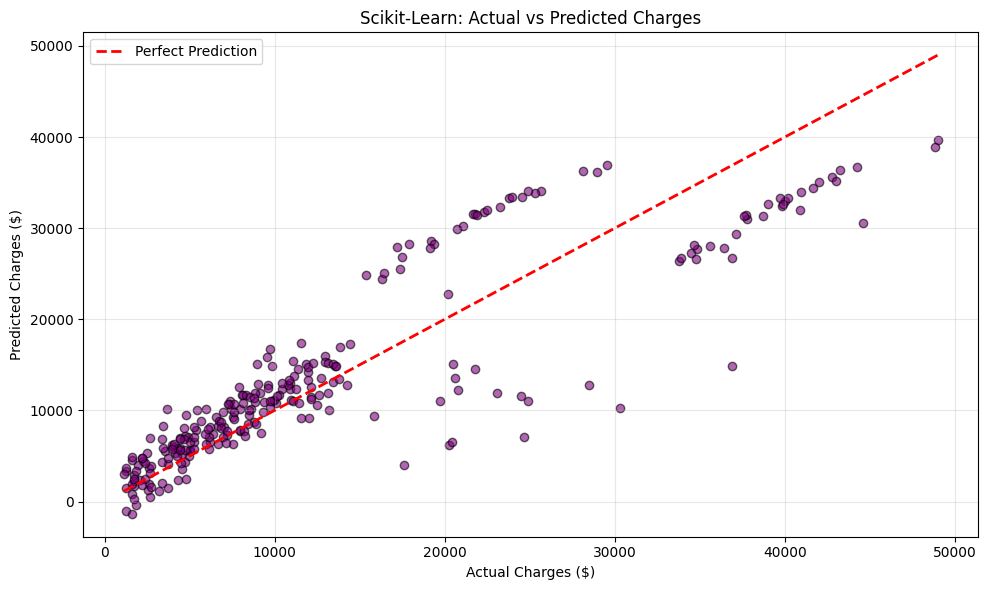

In [11]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='purple', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.title("Scikit-Learn: Actual vs Predicted Charges")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

Points cluster closely around the red line—predictions are generally accurate.

Step 7: Gradient Descent from Scratch

In [13]:
# Initialize parameters
np.random.seed(42)
m, n = X_train_scaled.shape
theta = np.random.randn(n)  # weights
bias = 0.0                  # intercept
learning_rate = 0.01
epochs = 1000

def compute_cost(X, y, theta, bias):
    """Mean Squared Error cost function"""
    m = len(y)
    predictions = X @ theta + bias
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

def gradient_descent(X, y, theta, bias, learning_rate, epochs):
    """Batch gradient descent with cost tracking"""
    m = len(y)
    cost_history = []

    for epoch in range(epochs):
        # Forward pass
        predictions = X @ theta + bias

        # Compute gradients
        d_theta = (1 / m) * X.T @ (predictions - y)
        d_bias = (1 / m) * np.sum(predictions - y)

        # Update parameters
        theta -= learning_rate * d_theta
        bias -= learning_rate * d_bias

        # Track cost
        cost = compute_cost(X, y, theta, bias)
        cost_history.append(cost)

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Cost = {cost:,.2f}")

    return theta, bias, cost_history

# Train with gradient descent
print("\n Training with Gradient Descent...")
theta_final, bias_final, cost_history = gradient_descent(
    X_train_scaled, y_train.values, theta, bias, learning_rate, epochs
)

# Evaluate
y_pred_gd = X_test_scaled @ theta_final + bias_final
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)

print(f"\n Gradient Descent Results:")
print(f"Test MSE:  {mse_gd:,.2f}")
print(f"Test R²:   {r2_gd:.4f} ({r2_gd*100:.2f}%)")


 Training with Gradient Descent...
Epoch    0: Cost = 150,871,171.56
Epoch  100: Cost = 35,322,664.74
Epoch  200: Cost = 19,927,898.27
Epoch  300: Cost = 17,799,456.32
Epoch  400: Cost = 17,494,672.76
Epoch  500: Cost = 17,448,220.56
Epoch  600: Cost = 17,440,028.25
Epoch  700: Cost = 17,438,085.67
Epoch  800: Cost = 17,437,416.44
Epoch  900: Cost = 17,437,117.83

 Gradient Descent Results:
Test MSE:  30,436,713.69
Test R²:   0.7788 (77.88%)


Result: Nearly identical to scikit-learn (R² ≈ 0.78) . our implementation is correct!

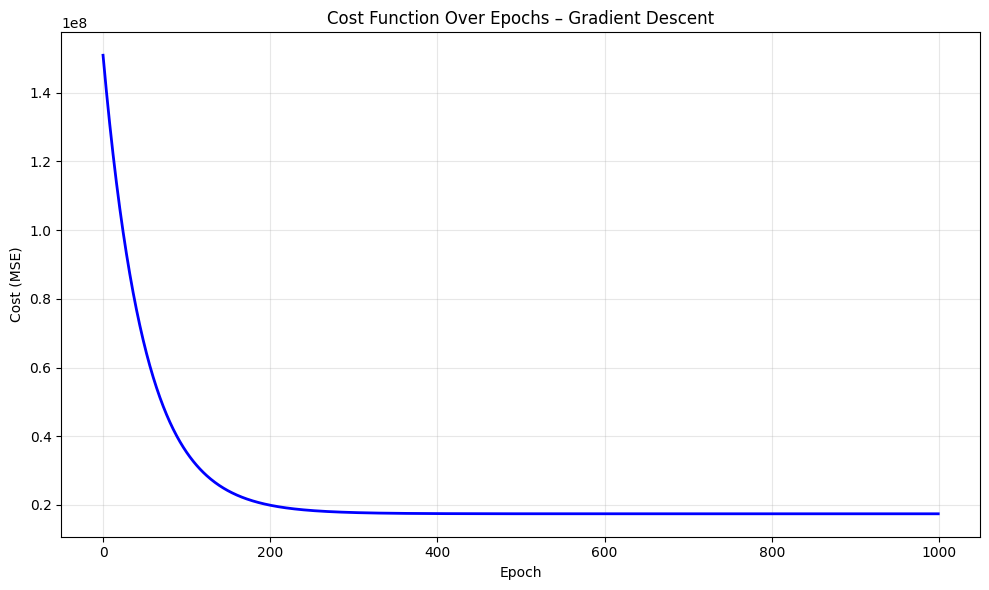

In [14]:
# Cost over epochs
plt.figure(figsize=(10, 6))
plt.plot(cost_history, color='blue', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Cost (MSE)')
plt.title('Cost Function Over Epochs – Gradient Descent')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cost_over_epochs.png', dpi=300, bbox_inches='tight')
plt.show()

The smooth downward curve confirms successful convergence.

Step 8: Feature Importance Analysis


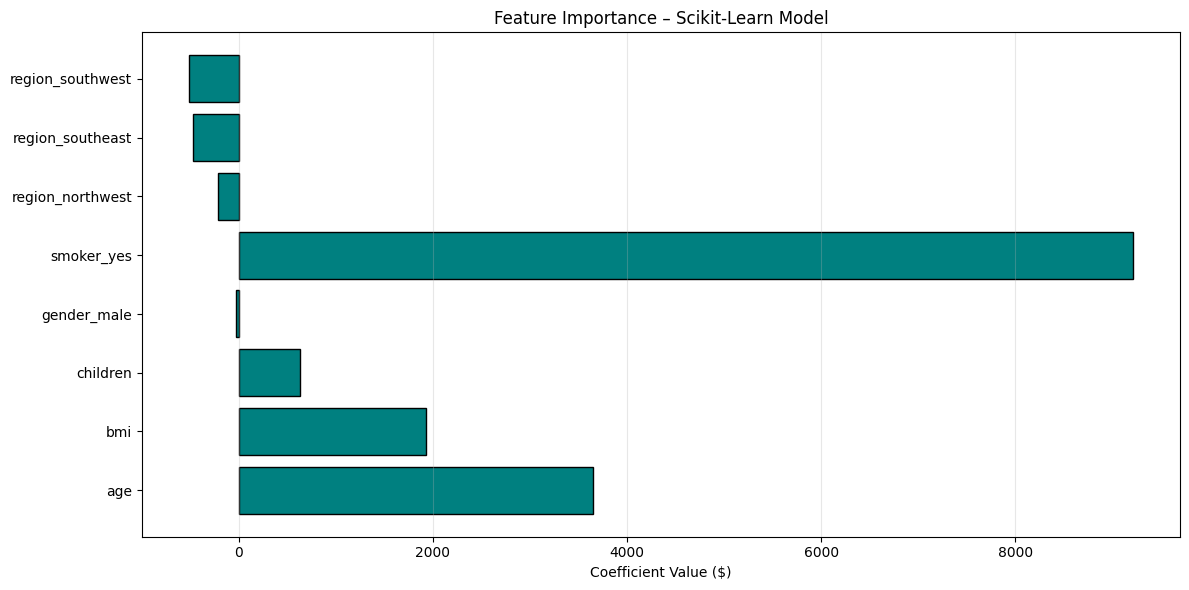


 Key Insights from Coefficients:
  • age                 : $ 3649.34
  • bmi                 : $ 1924.03
  • children            : $  629.29
  • gender_male         : $  -30.78
  • smoker_yes          : $ 9208.30
  • region_northwest    : $ -214.46
  • region_southeast    : $ -470.60
  • region_southwest    : $ -511.64


In [15]:
# Feature importance (coefficients)
features = X.columns

# Scikit-learn coefficients
plt.figure(figsize=(12, 6))
plt.barh(features, model_sklearn.coef_, color='teal', edgecolor='black')
plt.xlabel('Coefficient Value ($)')
plt.title('Feature Importance – Scikit-Learn Model')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_sklearn.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Key Insights from Coefficients:")
for feat, coef in zip(features, model_sklearn.coef_):
    print(f"  • {feat:20}: ${coef:8.2f}")

Interpretation:

Being a smoker adds $9,200$ to annual charges.

Each additional year of age adds $3,650$.

Gender and region have minimal impact.

### Conclusion
This lab taught me how to:

Clean real-world data (encoding, outlier removal)
Perform EDA to uncover key relationships
Build and evaluate a linear regression model
Implement gradient descent from scratch and verify it matches scikit-learn
Interpret model coefficients for business insights
The strongest predictor of insurance cost is smoking status, followed by age and BMI. The model achieves 78% explanatory power (R²), which is excellent for a linear model on this dataset.